In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


(784,)


In [3]:
learning_rate = 0.01
training_iters = 5000  # Number of training batches
batch_size = 128       # Batch size

n_input = 784   # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)

x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

In [4]:
# Conv2D wrapper, with bias and relu activation
def conv2d(x, W, b, name, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x,name=name)

# Conv2D wrapper, with bias and relu activation
def conv2d_norelu(x, W, b, name, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b, name=name)
    return x

# MaxPool2D wrapper
def maxpool2d(x, name, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME',name=name)


# Create model
def conv_net(x, weights, biases):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1],name="reshapedInput")

    # Convolution Layer 1
    conv1 = conv2d(x, weights['wc1'], biases['bc1'],name="conv1")
    conv1 = maxpool2d(conv1, k=2,name="maxpool1")
    print(conv1.get_shape())

    # Convolution Layer 2
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'],name="conv2")
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2,name="maxpool2")
    print(conv2.get_shape())

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])

    # Output, class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'],name="last10nodes")
    return out

In [5]:
# Layer weights
weights = {
    # 5x5 conv, 1 input, 16 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 16])),
    # 5x5 conv, 32 inputs, 32 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 16, 32])),
    # fully connected, 7*7*32 inputs, 128 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*32, 128])),
    # fully connected, 128 inputs, 10 outputs
    'wd2': tf.Variable(tf.random_normal([128, 10])),
    'out': tf.Variable(tf.random_normal([10, n_classes]))
}

# Layer biases
biases = {
    'bc1': tf.Variable(tf.random_normal([16])),
    'bc2': tf.Variable(tf.random_normal([32])),
    'bd1': tf.Variable(tf.random_normal([128])),
    'bd2': tf.Variable(tf.random_normal([10])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases)
y_pred = tf.nn.softmax(logits=pred)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

(?, 14, 14, 16)
(?, 7, 7, 32)


In [6]:
# Launch the graph
best_valid_acc=0.0

with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
                
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
        if step % 100 == 0:
            # Calculate batch loss and accuracy       
            loss, acc= sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
            
            valid_acc=sess.run(accuracy, feed_dict={x: mnist.test.images[:3000],
                                                   y: mnist.test.labels[:3000]})
            
            if (best_valid_acc<valid_acc) and (acc-valid_acc<=0.03):
                tf.train.Saver().save(sess, "/tmp/model.ckpt")
                best_valid_acc=valid_acc
            
            print("Iter " + str(step) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)+ ", Validation Accuracy= " + \
                  "{:.5f}".format(valid_acc))
        step += 1
    print("Training Finished!")

    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy after Training:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[3001:],
                                      y: mnist.test.labels[3001:]}))
    
    tf.train.Saver().restore(sess, "/tmp/model.ckpt")
    print("Testing Accuracy Corresponding to Best Validation:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[3001:],
                                      y: mnist.test.labels[3001:]}))
    
    #tf.train.Saver().save(sess, "/tmp/model.ckpt")

Iter 100, Minibatch Loss= 771.458008, Training Accuracy= 0.70312, Validation Accuracy= 0.75533
Iter 200, Minibatch Loss= 231.985977, Training Accuracy= 0.85156, Validation Accuracy= 0.83600
Iter 300, Minibatch Loss= 151.199524, Training Accuracy= 0.92188, Validation Accuracy= 0.87400
Iter 400, Minibatch Loss= 70.674896, Training Accuracy= 0.90625, Validation Accuracy= 0.90133
Iter 500, Minibatch Loss= 82.688408, Training Accuracy= 0.92188, Validation Accuracy= 0.91033
Iter 600, Minibatch Loss= 51.051983, Training Accuracy= 0.95312, Validation Accuracy= 0.91467
Iter 700, Minibatch Loss= 42.704041, Training Accuracy= 0.95312, Validation Accuracy= 0.92667
Iter 800, Minibatch Loss= 30.116432, Training Accuracy= 0.96094, Validation Accuracy= 0.93033
Iter 900, Minibatch Loss= 33.386585, Training Accuracy= 0.94531, Validation Accuracy= 0.92800
Iter 1000, Minibatch Loss= 7.910792, Training Accuracy= 0.98438, Validation Accuracy= 0.93367
Iter 1100, Minibatch Loss= 7.588896, Training Accuracy= 0

In [7]:
#tf.train.Saver().restore(sess, "/tmp/model.ckpt")

def normalize_image(x):
    # Get the min and max values for all pixels in the input.
    x_min = x.min()
    x_max = x.max()

    # Normalize so all values are between 0.0 and 1.0
    x_norm = (x - x_min) / (x_max - x_min)

    return x_norm

def plot_image(image):
    # Normalize the image so pixels are between 0.0 and 1.0
    #img_norm = normalize_image(image)
    
    plt.imshow(np.reshape(image,[28,28]),  cmap="gray")
    #plt.imshow(np.reshape(image,[28,28]), cmap="gray")
    plt.show()

Predicted digit of the image: 9


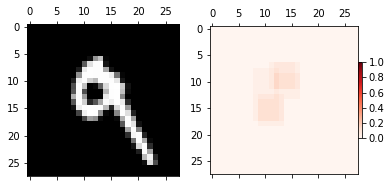

Predicted digit of the image: 9


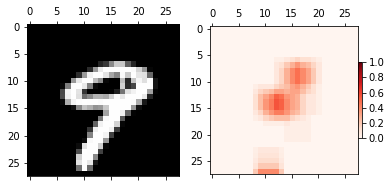

Predicted digit of the image: 9


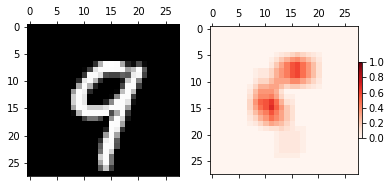

Predicted digit of the image: 9


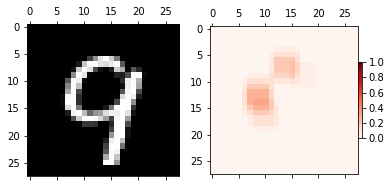

Predicted digit of the image: 9


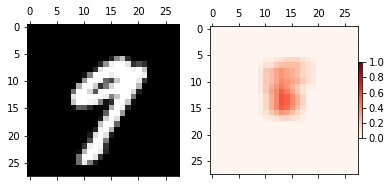

Predicted digit of the image: 9


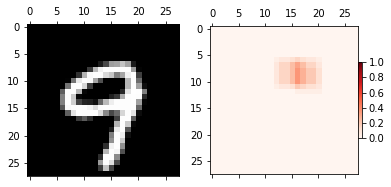

Predicted digit of the image: 9


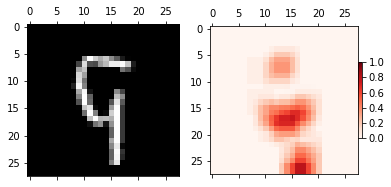

Predicted digit of the image: 9


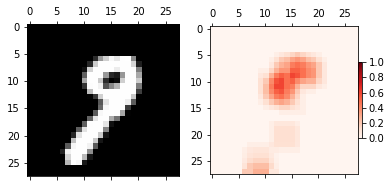

Predicted digit of the image: 9


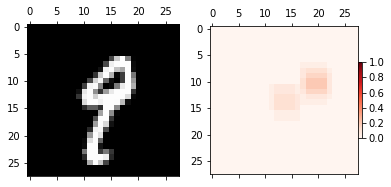

Predicted digit of the image: 9


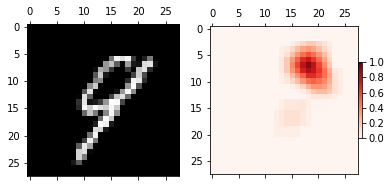

Predicted digit of the image: 9


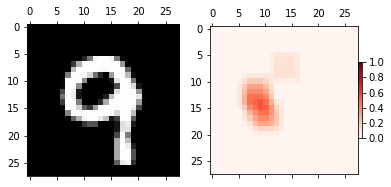

Predicted digit of the image: 9


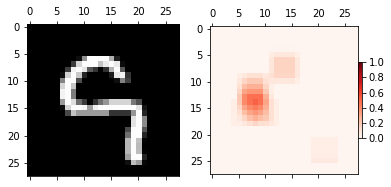

Predicted digit of the image: 9


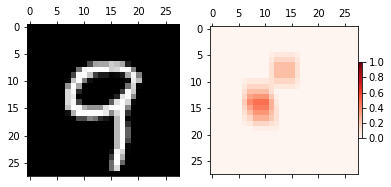

Predicted digit of the image: 9


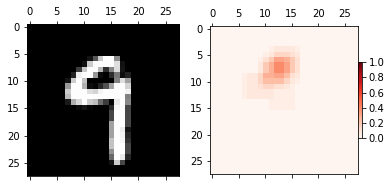

Predicted digit of the image: 9


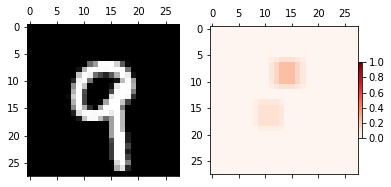

Predicted digit of the image: 9


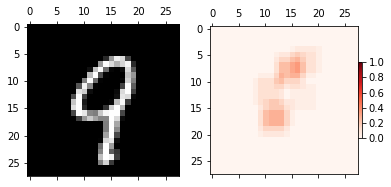

Predicted digit of the image: 9


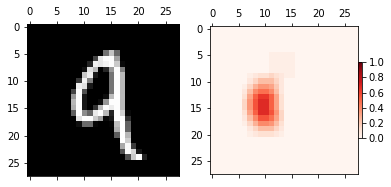

Predicted digit of the image: 9


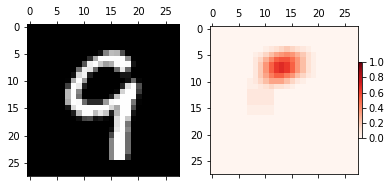

Predicted digit of the image: 9


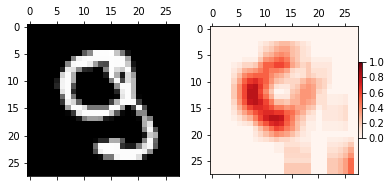

Predicted digit of the image: 9


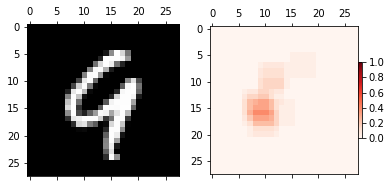

Predicted digit of the image: 9


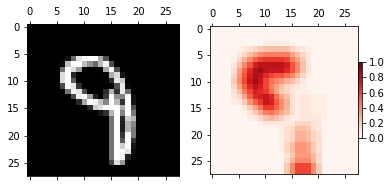

Predicted digit of the image: 9


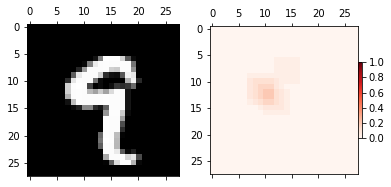

Predicted digit of the image: 9


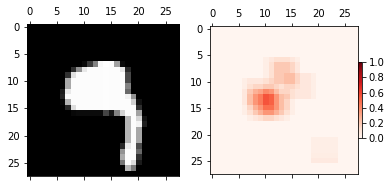

Predicted digit of the image: 9


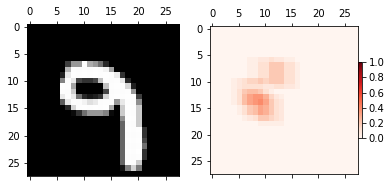

Predicted digit of the image: 9


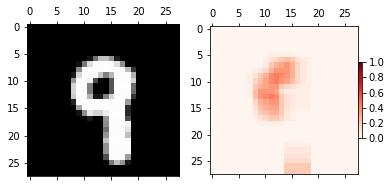

Predicted digit of the image: 9


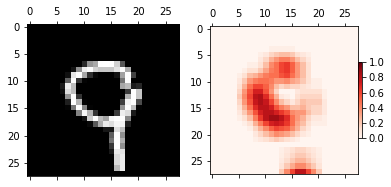

Predicted digit of the image: 9


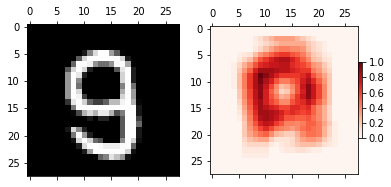

Predicted digit of the image: 9


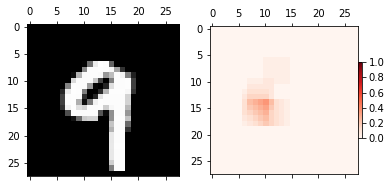

Predicted digit of the image: 9


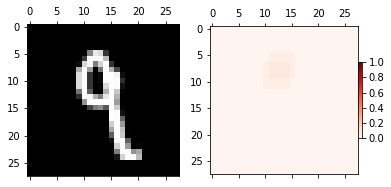

Predicted digit of the image: 9


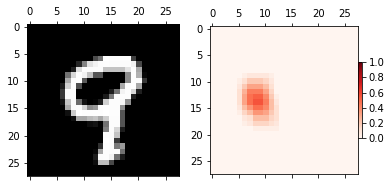

Predicted digit of the image: 9


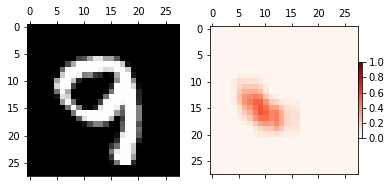

Predicted digit of the image: 9


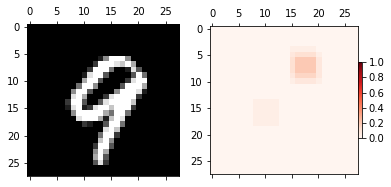

Predicted digit of the image: 9


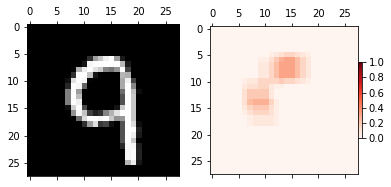

Predicted digit of the image: 9


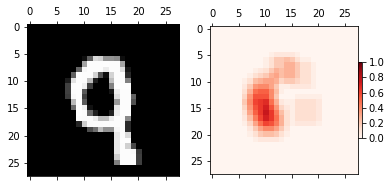

Predicted digit of the image: 9


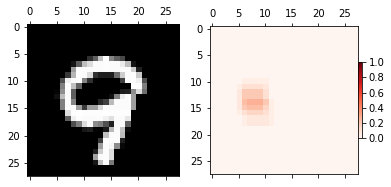

Predicted digit of the image: 8


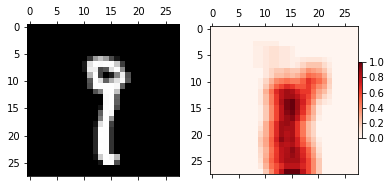

Predicted digit of the image: 9


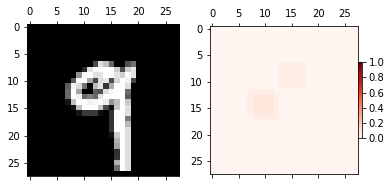

Predicted digit of the image: 9


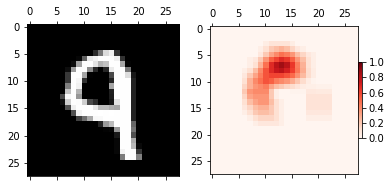

Predicted digit of the image: 9


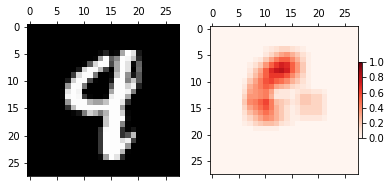

Predicted digit of the image: 9


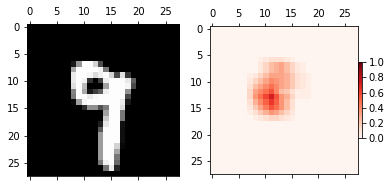

Predicted digit of the image: 9


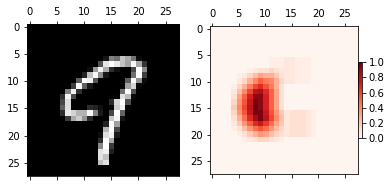

Predicted digit of the image: 9


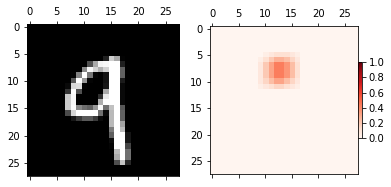

Predicted digit of the image: 9


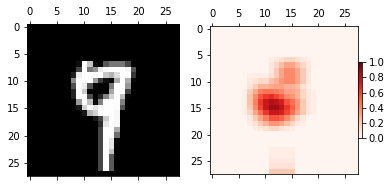

Predicted digit of the image: 9


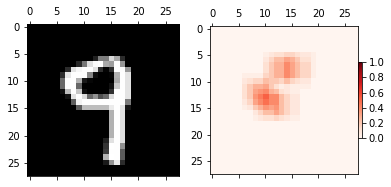

Predicted digit of the image: 9


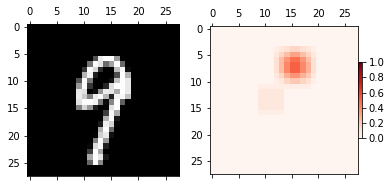

Predicted digit of the image: 9


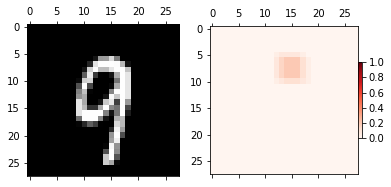

Predicted digit of the image: 8


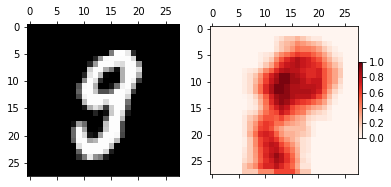

Predicted digit of the image: 9


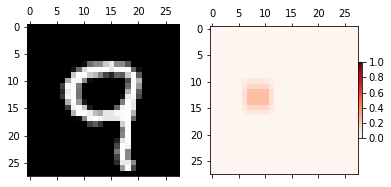

Predicted digit of the image: 9


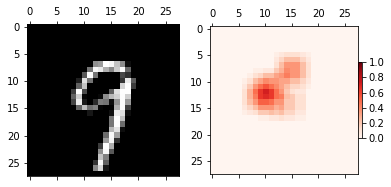

Predicted digit of the image: 9


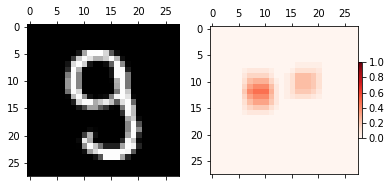

Predicted digit of the image: 9


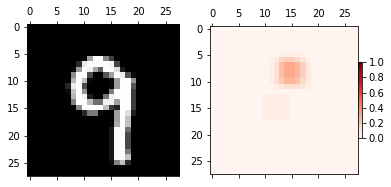

Predicted digit of the image: 9


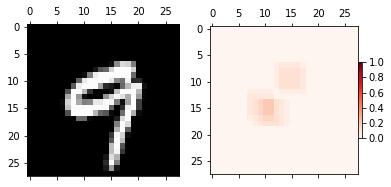

Predicted digit of the image: 9


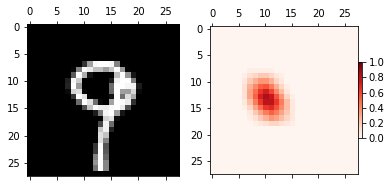

Predicted digit of the image: 9


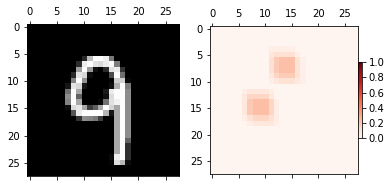

In [8]:
def createOcclusion(im,roi_size):     
    iters = (28-roi_size+1) 
    batch_size = iters**2+1
    batch = np.ndarray([batch_size, 28, 28,1])
    i = 0
    for r in range(0,iters):
        for c in range(0,iters):
            imOc = np.copy(im)
            imOc[r:r+roi_size-1,c:c+roi_size-1,0] = 0            
            batch[i] = imOc           
            i = i + 1
    batch[i] = np.copy(im)
    return batch

def softmax(w):
    w = np.array(w)
    maxes = np.amax(w, axis=1)
    maxes = maxes.reshape(maxes.shape[0], 1)
    e = np.exp(w-maxes) # The "max trick"
    dist = e / np.sum(e, axis=1)[:,None]
    return dist

def createOcclusionHeatMap(img,roi_size):
    with tf.Session() as sess:
        tf.train.Saver().restore(sess, "/tmp/model.ckpt")
        model=sess.graph
        occulationBatch=createOcclusion(img,roi_size)
        feed_dict = {x: occulationBatch.reshape(len(occulationBatch),784)}
        y_preds, preds = sess.run([y_pred, pred],feed_dict=feed_dict)
        
        cl=np.argmax(y_preds[-1])
        print("Predicted digit of the image: "+str(cl))
        org_prob=np.max(y_preds[-1])
        
        count_map=np.zeros((28,28))
        prob_map=np.zeros((28,28))
        #prob_map=np.ones((28,28))
        hmdim=(28-roi_size+1)
        k=0
        for i in range(hmdim):
            for j in range(hmdim):
                prob=y_preds[k][cl]
                if prob<0.0:
                    print(preds[k])
                    print(y_preds[k])
                k+=1
                count_map[i:i+roi_size,j:j+roi_size]+=1.0
                prob_map[i:i+roi_size,j:j+roi_size]+=prob
                #for ip in range(i,i+roi_size):
                #    for jp in range(j,j+roi_size):
                #        prob_map[ip,jp]=min(prob,prob_map[ip,jp])

        for i in range(28):
            for j in range(28):
                if count_map[i,j]>0:
                    prob_map[i,j]/=count_map[i,j]
                    prob_map[i,j]=1.0-prob_map[i,j]
        
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].matshow(img.reshape(28,28),cmap='gray')
        pmap=axes[1].matshow(prob_map,cmap='Reds')
        cbar=plt.colorbar(pmap, fraction=0.025, pad=0.0)
        cbar.set_clim(0, 1.0)
        cbar.draw_all()
        plt.show()

Predicted digit of the image: 9


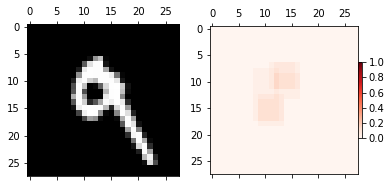

Predicted digit of the image: 9


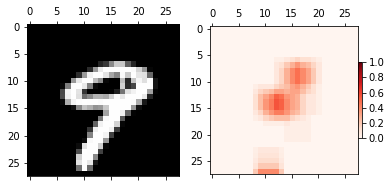

Predicted digit of the image: 9


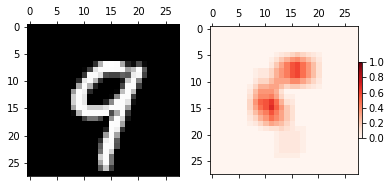

Predicted digit of the image: 9


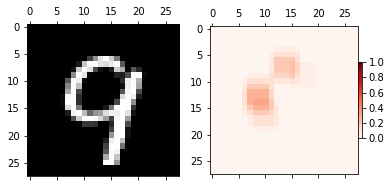

Predicted digit of the image: 9


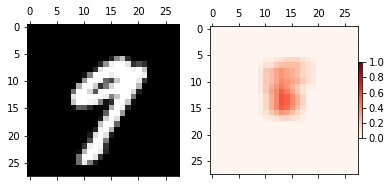

Predicted digit of the image: 9


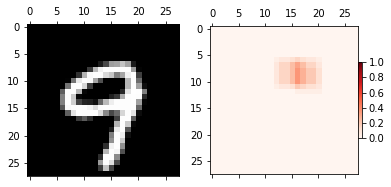

Predicted digit of the image: 9


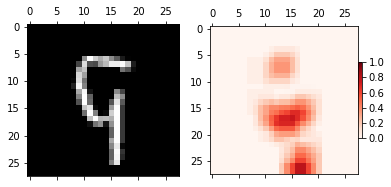

Predicted digit of the image: 9


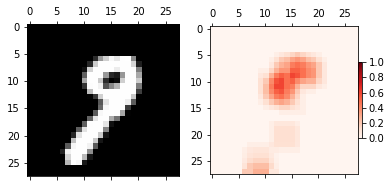

Predicted digit of the image: 9


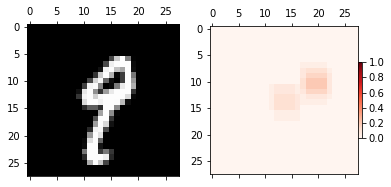

Predicted digit of the image: 9


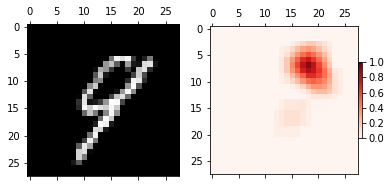

Predicted digit of the image: 9


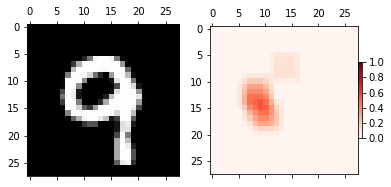

Predicted digit of the image: 9


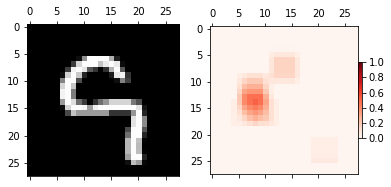

Predicted digit of the image: 9


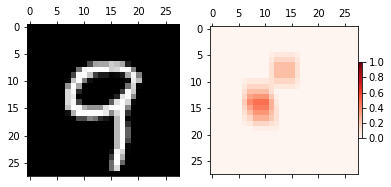

Predicted digit of the image: 9


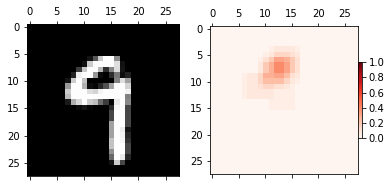

Predicted digit of the image: 9


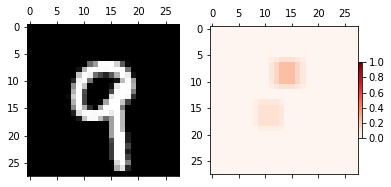

Predicted digit of the image: 9


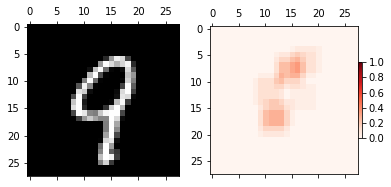

Predicted digit of the image: 9


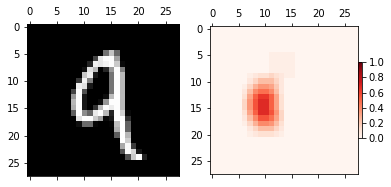

Predicted digit of the image: 9


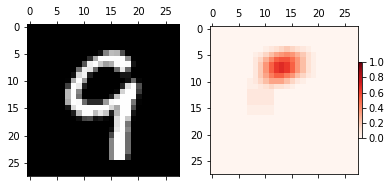

Predicted digit of the image: 9


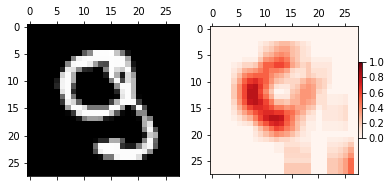

Predicted digit of the image: 9


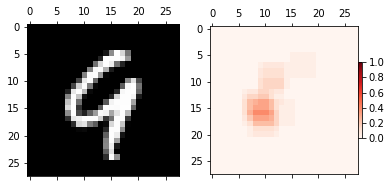

Predicted digit of the image: 9


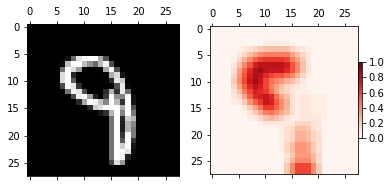

Predicted digit of the image: 9


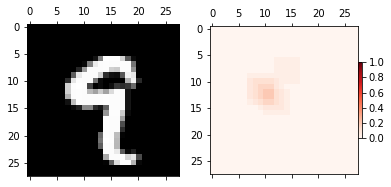

Predicted digit of the image: 9


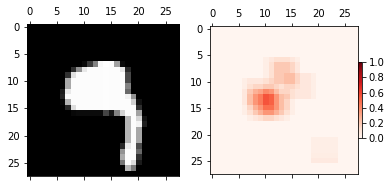

Predicted digit of the image: 9


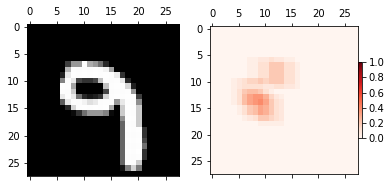

Predicted digit of the image: 9


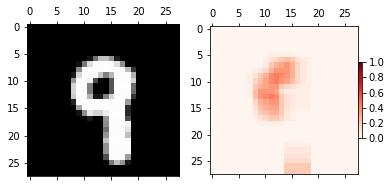

Predicted digit of the image: 9


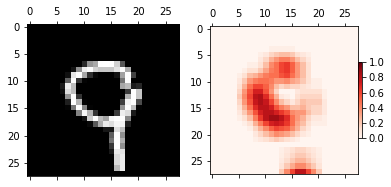

Predicted digit of the image: 9


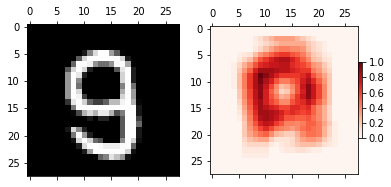

In [12]:
for i in range(250):
    if np.argmax(mnist.test.labels[i])==9:
        createOcclusionHeatMap(mnist.test.images[i].reshape(28,28,1),5)

In [9]:
@ops.RegisterGradient("GuidedBackprop")
def _GuidedBackpropGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops._relu_grad(grad, op.outputs[0]), tf.zeros_like(grad))

In [43]:
def guided_relu_map(img,feature=0):    
    with tf.Session() as sess:
        tf.train.Saver().restore(sess, "/tmp/model.ckpt")
        model=sess.graph
        
        with tf.get_default_graph().gradient_override_map({'Relu': 'GuidedBackprop'}):
            pred = conv_net(x, weights, biases)
            gradient = tf.gradients(pred[0,feature], x)

        feed_dict = {x: img.reshape(1,784)} 
        pred_v, grad=sess.run([pred,gradient],feed_dict=feed_dict) 

        img=img.reshape(28,28)
        guided_backprop_map=np.abs(grad[0].reshape(28,28))
        guided_backprop_map/=np.max(guided_backprop_map)

        
        fig, axes = plt.subplots(nrows=1, ncols=2)
        axes[0].matshow(img.reshape(28,28),cmap='gray')
        pmap=axes[1].matshow(guided_backprop_map.reshape(28,28),cmap='Reds')
        cbar=plt.colorbar(pmap, fraction=0.025, pad=0.0)
        cbar.set_clim(0, 1.0)
        cbar.draw_all()
        plt.show()

(?, 14, 14, 16)
(?, 7, 7, 32)


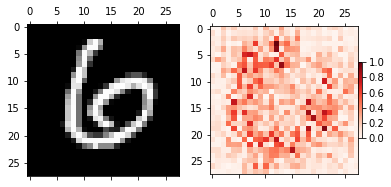

(?, 14, 14, 16)
(?, 7, 7, 32)


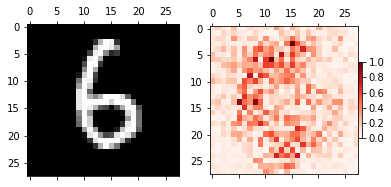

(?, 14, 14, 16)
(?, 7, 7, 32)


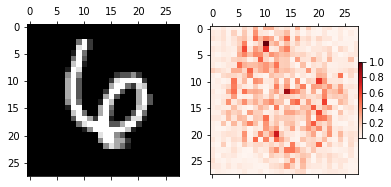

(?, 14, 14, 16)
(?, 7, 7, 32)


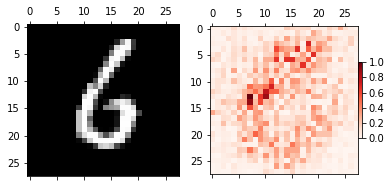

(?, 14, 14, 16)
(?, 7, 7, 32)


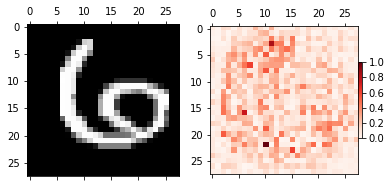

(?, 14, 14, 16)
(?, 7, 7, 32)


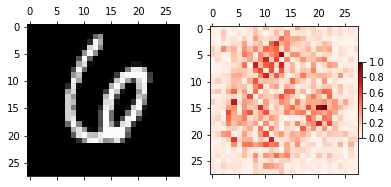

(?, 14, 14, 16)
(?, 7, 7, 32)


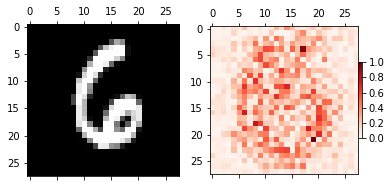

(?, 14, 14, 16)
(?, 7, 7, 32)


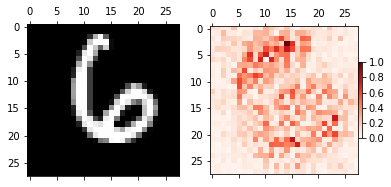

(?, 14, 14, 16)
(?, 7, 7, 32)


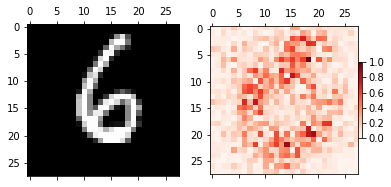

(?, 14, 14, 16)
(?, 7, 7, 32)


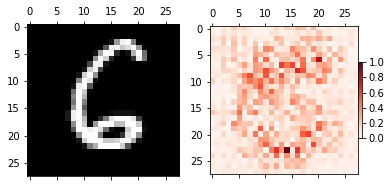

(?, 14, 14, 16)
(?, 7, 7, 32)


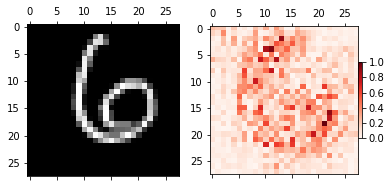

(?, 14, 14, 16)
(?, 7, 7, 32)


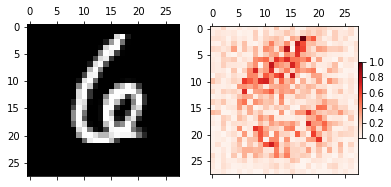

(?, 14, 14, 16)
(?, 7, 7, 32)


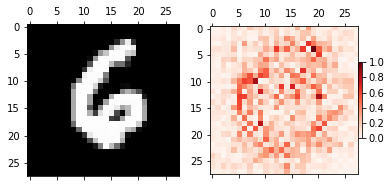

(?, 14, 14, 16)
(?, 7, 7, 32)


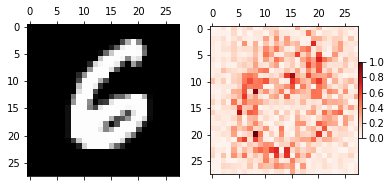

(?, 14, 14, 16)
(?, 7, 7, 32)


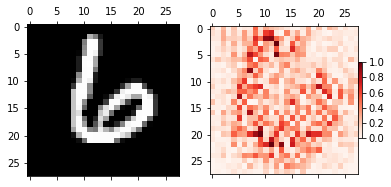

(?, 14, 14, 16)
(?, 7, 7, 32)


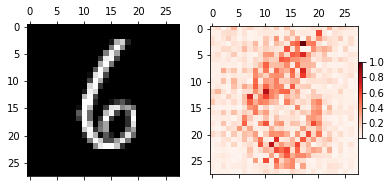

(?, 14, 14, 16)
(?, 7, 7, 32)


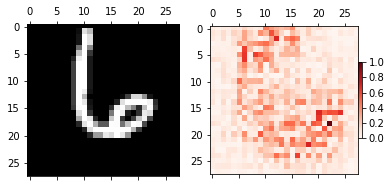

(?, 14, 14, 16)
(?, 7, 7, 32)


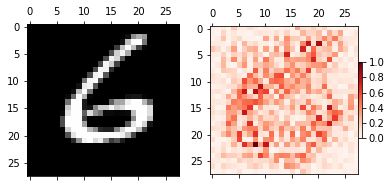

(?, 14, 14, 16)
(?, 7, 7, 32)


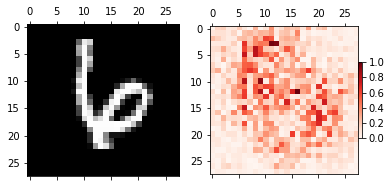

(?, 14, 14, 16)
(?, 7, 7, 32)


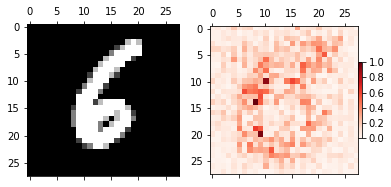

(?, 14, 14, 16)
(?, 7, 7, 32)


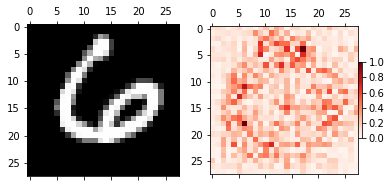

(?, 14, 14, 16)
(?, 7, 7, 32)


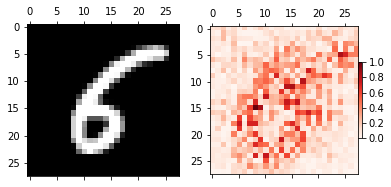

In [48]:
for i in range(250):
    if np.argmax(mnist.test.labels[i])==6:
        guided_relu_map(mnist.test.images[i],np.argmax(mnist.test.labels[i]))

### Reference

Visualizing and Understanding Convolutional Networks. M.D. Zeiler, R. Fergus. ECCV 2014. Arxiv 1311.2901 (Nov 28, 2013)

Striving for simplicity: The all convolutional net. JT Springenberg, A Dosovitskiy, T Brox, M Riedmiller. arXiv preprint arXiv:1412.6806?